# 3-methods comparison

Summary  → ./Results/post-processing/buffer/comparison_packets.csv


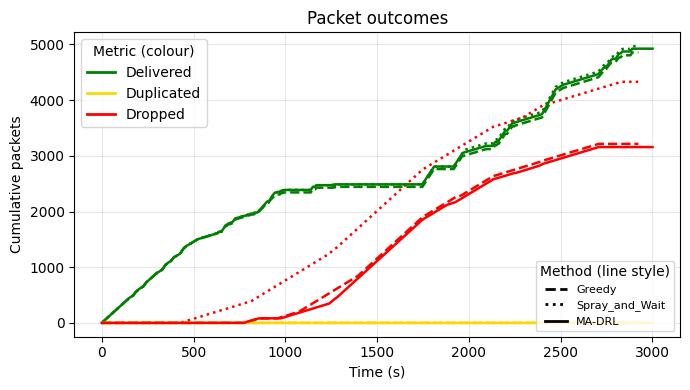

Figure saved in ./Results/post-processing/buffer/comparison_packets.png


,Delivered,Duplicated,Dropped
Method,,,
Greedy,4856.0,0.0,3215.0
Spray_and_Wait,4970.0,8.0,4330.0
MA-DRL,4925.0,0.0,3158.0


In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def compare_comm_policies(methods,
                          base_dir='./Results/post-processing/buffer',
                          csv_prefix='csv_',
                          fig_name='comparison_packets.png',
                          summary_csv='comparison_packets.csv'):
    """
    One‑page chart: colour encodes {delivered, duplicated, dropped},
    line‑style encodes the comm. method (order in *methods*).

    CSV expected in
        <base_dir>/<csv_prefix><method>/effective_packets_cdf.csv
    with columns: time, delivered, duplicated, dropped[, total].
    """
    # ----------- load data -------------------------------------------------
    style_cycle = ['--', ':', '-']   # extend if you have >3 methods
    colour_map  = {'delivered': 'green',
                   'duplicated': 'gold',
                   'dropped': 'red'}

    records, data_ts = [], {}
    for m in methods:
        path = os.path.join(base_dir, f'{csv_prefix}{m}',
                            'effective_packets_cdf.csv')
        if not os.path.isfile(path):
            print(f'⚠  missing for {m}: {path}')
            continue

        df = pd.read_csv(path)
        df.columns = df.columns.str.strip()
        df = df.loc[:, ~df.columns.duplicated()]

        if 'time' not in df.columns:
            df.insert(0, 'time', range(len(df)))

        data_ts[m] = df
        last = df.iloc[-1]
        records.append({'Method':     m,
                        'Delivered':  last['delivered'],
                        'Duplicated': last['duplicated'],
                        'Dropped':    last['dropped']})

    if not data_ts:
        print('Nothing to plot.')
        return None

    # ----------- save end‑counts summary -----------------------------------
    summary = (pd.DataFrame(records)
               .set_index('Method')
               .loc[methods])
    summary.to_csv(os.path.join(base_dir, summary_csv))
    print('Summary  →', os.path.join(base_dir, summary_csv))

    # ----------- single chart ---------------------------------------------
    plt.figure(figsize=(7, 4))
    for idx, m in enumerate(methods):
        if m not in data_ts:
            continue
        df    = data_ts[m]
        style = style_cycle[idx % len(style_cycle)]

        for metric, colour in colour_map.items():
            plt.plot(df['time'].values,
                     df[metric].values,
                     linestyle=style,
                     color=colour,
                     linewidth=1.8)

    plt.xlabel('Time (s)')
    plt.ylabel('Cumulative packets')
    # plt.yscale('log')
    plt.title('Packet outcomes')
    plt.grid(True, alpha=0.3)

    # --- custom legends ----------------------------------------------------
    handles_metric = [Line2D([0], [0], color=c, lw=2) for c in colour_map.values()]
    labels_metric  = [k.capitalize() for k in colour_map.keys()]

    handles_method = [Line2D([0], [0], color='black', lw=2,
                             linestyle=style_cycle[i % len(style_cycle)])
                      for i, _ in enumerate(methods)]
    labels_method  = methods

    first  = plt.legend(handles_metric, labels_metric,
                        title='Metric (colour)', loc='upper left')
    plt.gca().add_artist(first)   # keep first legend

    plt.legend(handles_method, labels_method,
               title='Method (line style)', loc='lower right', fontsize=8)

    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(base_dir, fig_name), dpi=300)
    plt.close()
    print('Figure saved in', os.path.join(base_dir, fig_name))
    return summary


comm_policies = ['Greedy', 'Spray_and_Wait', 'MA-DRL']
# comm_policies = ['Spray_and_Wait', 'MA-DRL']
# comm_policies = ['Spray_and_Wait', 'MA-DRL']
compare_comm_policies(comm_policies)


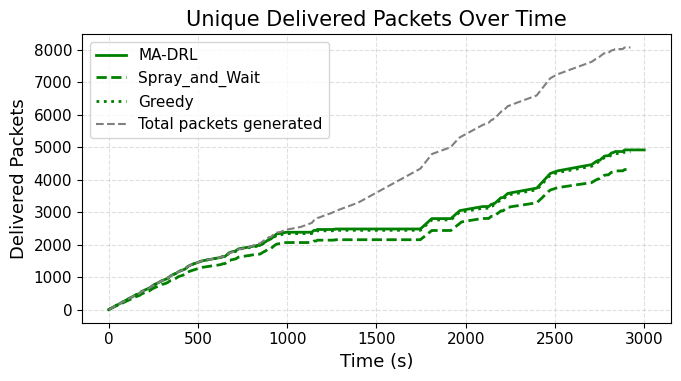

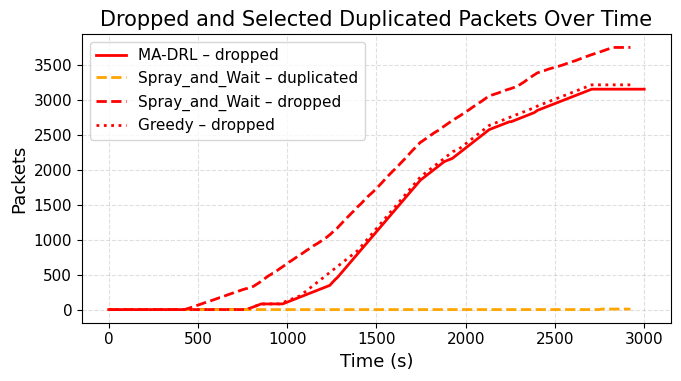

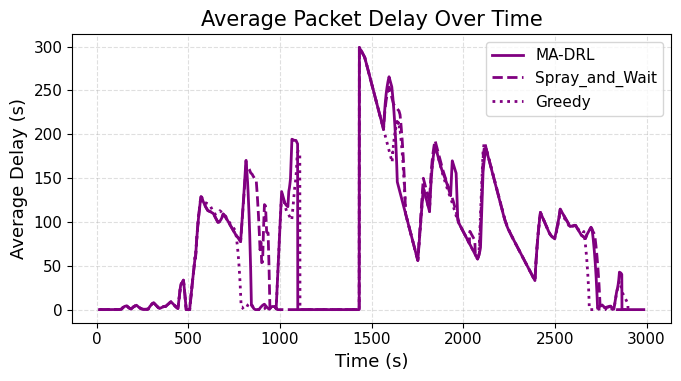

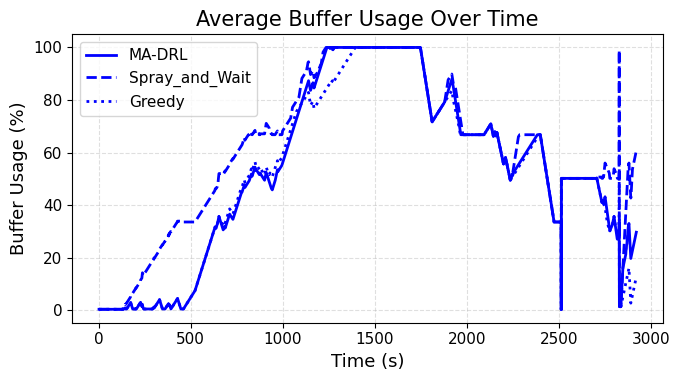

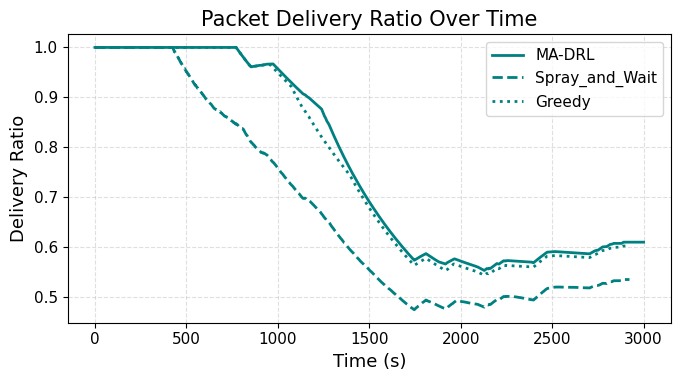

Summary  → ./Results/post-processing/buffer/comparison_packets.csv
                Delivered  Duplicated  Dropped
Method                                        
MA-DRL             4918.0         0.0   3153.0
Spray_and_Wait     4313.0         8.0   3750.0
Greedy             4856.0         0.0   3215.0


['./Results/post-processing/buffer/enhanced_delivered_packets.png',
 './Results/post-processing/buffer/enhanced_losses_packets.png',
 './Results/post-processing/buffer/enhanced_avg_delay.png',
 './Results/post-processing/buffer/enhanced_avg_buffer.png',
 './Results/post-processing/buffer/enhanced_delivery_ratio.png']

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
import random

# --- make all text a bit larger -------------------------------------------
mpl.rcParams.update({
    "font.size":        13,
    "axes.labelsize":   13,
    "axes.titlesize":   15,
    "legend.fontsize":  11,
    "xtick.labelsize":  11,
    "ytick.labelsize":  11,
})

# ---------- helpers ----------------------------------------------------------
def load_cdf(base_dir, method):
    """Load effective_packets_cdf.csv for one method."""
    path = os.path.join(base_dir, f'csv_{method}', 'effective_packets_cdf.csv')
    return np.loadtxt(path, delimiter=",", skiprows=1)

def random_reduce_to_equal_total(cdf_arrays, target_total=None):
    """Randomly remove packets from delivered/dropped/duplicated to match common total."""
    final_totals = [a[-1, 1] + a[-1, 2] + a[-1, 3] for a in cdf_arrays]
    min_total = min(final_totals) if target_total is None else target_total

    def build_cumulative(counts):
        return np.cumsum(np.maximum(counts, 0))

    adjusted_arrays = []

    for a in cdf_arrays:
        total = int(a[-1, 1] + a[-1, 2] + a[-1, 3])
        excess = int(round(total - min_total))
        if excess <= 0:
            adjusted_arrays.append(a.copy())
            continue

        d_incr = np.diff(np.insert(a[:, 1], 0, 0))
        r_incr = np.diff(np.insert(a[:, 2], 0, 0))
        u_incr = np.diff(np.insert(a[:, 3], 0, 0))

        packet_list = []
        for i in range(len(a)):
            packet_list.extend([('delivered', i)] * int(d_incr[i]))
            packet_list.extend([('dropped', i)] * int(r_incr[i]))
            packet_list.extend([('duplicated', i)] * int(u_incr[i]))

        random.seed(42)
        random.shuffle(packet_list)
        for ptype, i in packet_list[:excess]:
            if ptype == 'delivered': d_incr[i] -= 1
            elif ptype == 'dropped': r_incr[i] -= 1
            elif ptype == 'duplicated': u_incr[i] -= 1

        d_adj = build_cumulative(d_incr)
        r_adj = build_cumulative(r_incr)
        u_adj = build_cumulative(u_incr)

        adj = a.copy()
        adj[:, 1] = d_adj
        adj[:, 2] = r_adj
        adj[:, 3] = u_adj
        adjusted_arrays.append(adj)

    return adjusted_arrays
# -----------------------------------------------------------------------------

def generate_comparison_plots(methods,
                              base_dir='./Results/post-processing/',
                              plot=False,
                              trim_packets=True):
    os.makedirs(base_dir, exist_ok=True)

    style_map = {'MA-DRL': '-', 'Spray_and_Wait': '--', 'Greedy': ':'}
    color_map = dict(delivered='green', duplicated='orange', dropped='red',
                     avg_buffer='blue', avg_delay='purple', delivery_ratio='teal')

    # ---------- LOAD & (optionally) TRIM CDFs -------------------------------
    cdfs = [load_cdf(base_dir, m) for m in methods]
    if trim_packets:
        cdfs = random_reduce_to_equal_total(cdfs)
    cdf = dict(zip(methods, cdfs))
    # -----------------------------------------------------------------------

    fig_paths = []

    # -------- Figure 1 – Delivered ----------------------------------------
    plt.figure(figsize=(7, 4))
    for m in methods:
        t, delivered = cdf[m][:, 0], cdf[m][:, 1]
        plt.plot(t, delivered, linestyle=style_map[m],
                 color=color_map['delivered'], linewidth=2, label=m)

    if 'Greedy' in cdf:
        g = cdf['Greedy']
        total = g[:, 1] + g[:, 2] + g[:, 3]
        plt.plot(g[:, 0], total, '--', color='gray', lw=1.5,
                 label='Total packets generated')

    plt.xlabel('Time (s)')
    plt.ylabel('Delivered Packets')
    plt.title('Unique Delivered Packets Over Time')
    plt.grid(alpha=0.4, ls='--');  plt.legend()
    p = os.path.join(base_dir, 'enhanced_delivered_packets.png')
    plt.tight_layout();  plt.savefig(p, dpi=300) if not plot else plt.show()
    plt.close();  fig_paths.append(p)

    # -------- Figure 2 – Drops & Duplicates --------------------------------
    plt.figure(figsize=(7, 4))
    for m in methods:
        t, dropped = cdf[m][:, 0], cdf[m][:, 2]
        dup = cdf[m][:, 3]
        if m == 'Spray_and_Wait':
            plt.plot(t, dup, linestyle=style_map[m],
                     color=color_map['duplicated'], lw=2,
                     label=f'{m} – duplicated')
        plt.plot(t, dropped, linestyle=style_map[m],
                 color=color_map['dropped'], lw=2,
                 label=f'{m} – dropped')
    plt.xlabel('Time (s)');  plt.ylabel('Packets')
    plt.title('Dropped and Selected Duplicated Packets Over Time')
    plt.grid(alpha=0.4, ls='--');  plt.legend()
    p = os.path.join(base_dir, 'enhanced_losses_packets.png')
    plt.tight_layout();  plt.savefig(p, dpi=300) if not plot else plt.show()
    plt.close();  fig_paths.append(p)

    # -------- Figure 3 – Average Delay -------------------------------------
    plt.figure(figsize=(7, 4))
    for m in methods:
        path = os.path.join(base_dir, f'csv_{m}', 'avg_delay_total.csv')
        a = np.loadtxt(path, delimiter=",", skiprows=1)
        plt.plot(a[:, 0], a[:, 1], linestyle=style_map[m],
                 color=color_map['avg_delay'], lw=2, label=m)
    plt.xlabel('Time (s)');  plt.ylabel('Average Delay (s)')
    plt.title('Average Packet Delay Over Time')
    plt.grid(alpha=0.4, ls='--');  plt.legend()
    p = os.path.join(base_dir, 'enhanced_avg_delay.png')
    plt.tight_layout();  plt.savefig(p, dpi=300) if not plot else plt.show()
    plt.close();  fig_paths.append(p)

    # -------- Figure 4 – Buffer Usage --------------------------------------
    plt.figure(figsize=(7, 4))
    for m in methods:
        path = os.path.join(base_dir, f'csv_{m}', 'average_buffer.csv')
        a = np.loadtxt(path, delimiter=",", skiprows=1)
        plt.plot(a[:, 0], a[:, 1], linestyle=style_map[m],
                 color=color_map['avg_buffer'], lw=2, label=m)
    plt.xlabel('Time (s)');  plt.ylabel('Buffer Usage (%)')
    plt.title('Average Buffer Usage Over Time')
    plt.grid(alpha=0.4, ls='--');  plt.legend()
    p = os.path.join(base_dir, 'enhanced_avg_buffer.png')
    plt.tight_layout();  plt.savefig(p, dpi=300) if not plot else plt.show()
    plt.close();  fig_paths.append(p)

    # -------- Figure 5 – Delivery Ratio ------------------------------------
    plt.figure(figsize=(7, 4))
    for m in methods:
        d = cdf[m]
        total = d[:, 1] + d[:, 2] + d[:, 3]
        total[total == 0] = 1
        ratio = d[:, 1] / total
        plt.plot(d[:, 0], ratio, linestyle=style_map[m],
                 color=color_map['delivery_ratio'], lw=2, label=m)
    plt.xlabel('Time (s)');  plt.ylabel('Delivery Ratio')
    plt.title('Packet Delivery Ratio Over Time')
    plt.grid(alpha=0.4, ls='--');  plt.legend()
    p = os.path.join(base_dir, 'enhanced_delivery_ratio.png')
    plt.tight_layout();  plt.savefig(p, dpi=300) if not plot else plt.show()
    plt.close();  fig_paths.append(p)

    # -------- Summary CSV ---------------------------------------------------
    summary_rows = []
    for m in methods:
        last = cdf[m][-1]
        summary_rows.append(dict(Method=m,
                                 Delivered= last[1],
                                 Duplicated=last[3],
                                 Dropped=   last[2]))
    summary = (pd.DataFrame(summary_rows)
               .set_index('Method')
               .loc[methods])
    csv_path = os.path.join(base_dir, 'comparison_packets.csv')
    summary.to_csv(csv_path)
    print('Summary  →', csv_path)
    print(summary)

    return fig_paths


# ---------------- Example call ----------------------------------------------
generate_comparison_plots(['MA-DRL', 'Spray_and_Wait', 'Greedy'],
                          base_dir='./Results/post-processing/buffer/',
                          plot=True, trim_packets=True)
